# Author: Seyi R. Afolayan
## Credits: Andrej Karpathy

# Homework 2: Programming

The following notebook contains skeleton-code for answering problems 2 and 3 of homework assignment 2. Please read through each cell carefully to understand what is expected to be implemented. For your final submission, please try to clean up any intermediate outputs used for debugging.

### Imports

You should be able to complete the entire assignment using only the following imports. Please consult the course staff if you are unsure about whether additional packages may be used.

In [ ]:
## Import Packages
import random
import numpy as np
import matplotlib.pyplot as plt
# Uploading the file
from google.colab import files
uploaded = files.upload()

Saving Q3_data.npz to Q3_data.npz


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Q4_data.npz to Q4_data.npz


## Question 2


Below we provide an AutoGrad class named `Value`. The basic idea is to store the existing computational map during the creation of each `Value`, and calculate the gradient using backpropagation when one of the `Value` calls `backward()` method.

The `backward()` function will arange the computational graph and backpropagate the gradients. All you need to do is to implement all the operations with its corresponding `_backward` function. We have provided the `__add__` function (sum of two nodes) as an example to help get you started.

This notebook is designed in a Object Oriented way, if you are not farmiliar with the Object Oriented Programming in Python, you can refer to:

(1) https://realpython.com/python3-object-oriented-programming/

(2) https://docs.python.org/3/tutorial/classes.html


In [ ]:
class Value:

    """
    Basic unit of storing a single scalar value and its gradient
    """

    def __init__(self, data, _children=()):
        """

        """
        self.data = data
        self.grad = 0
        self._prev = set(_children)
        self._backward = lambda: None # Default function (e.g leaf node) that does nothing.

    def __add__(self, other):
        """
        Example implementation of a single class operation (addition)

        Args:
            other (Any): Node to add with the class

        Returns:
            out (callable): Function to referesh the gradient
        """
        #Firstly, convert some default value type in python to Value
        #Then do operations with two or more Value object
        other = other if isinstance(other, Value) else Value(other)

        #Secondly, create a new Value object which is the result of the operation
        out = Value(self.data + other.data, (self, other))

        #Thirdly, create a _backward function for the output object to refresh
        # the gradient of its _childrens,
        #Then assign this _backward function to the output object.
        def _backward():
            self.grad += out.grad * 1.0
            other.grad += out.grad * 1.0
        out._backward = _backward

        return out

    def __mul__(self, other):
        """
        Multiplication operation (e.g. Value(3) * Value(2) = Value(6))
        """
        #TODO implement multiplication operation
        #Firstly, convert some default value type in python to Value
        #Then do operations with two or more Value object
        other = other if isinstance(other, Value) else Value(other)

        # Creating the output of the multiplication Value object
        out = Value(self.data * other.data, (self, other))

        #Then assign this _backward function to the output object.
        def _backward():
            # In the mul case, we need to perform swaps and also accumulate the gradients
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        """
        Power operation (e.g Value(3) ** 2 = Value(9))
        """
        #TODO implement power operation, we don't need to convert the exponent to Value
        assert isinstance(other, (int, float))

        # Creating the output value
        out = Value(self.data ** other, (self, )) # tuple of 1 child

        # Similarly, we run the _backward here
        def _backward():
          # In the pow case, we can either recall or google the d(x^n)/dx
          self.grad += (other * (self.data ** (other - 1))) * out.grad

        out._backward = _backward

        return out

    def relu(self):
        """
        ReLU activation function applied to the current Value
        """
        #TODO implement the relu activation function for the value itself.
        out = Value(0 if self.data < 0 else self.data, (self, ))

        # Similarly, we run the backward function to determine the gradient (local and upstream grad)
        def _backward():
          self.grad += (out.data > 0) * out.grad

        out._backward = _backward

        return out


    def exp(self):
        """
        Exponentiate the current Value (e.g. e ^ Value(0) = Value(1))
        """
        #TODO implement the exponential function for and treat the value as exponent.
        #The base is natural e, you can use numpy to calculate the value of the exponential.

        # Creating the output value for the exponential function
        out = Value(np.exp(self.data), (self, ))

        # Similarly, we run the backward function to determine the gradient (local and upstream grad)
        def _backward():
          self.grad += out.data * out.grad

        out._backward = _backward
        return out

    def log(self):
        """
        Take the natural logarithm (base e) of the current Value
        """
        #TODO implement the logarithm function for and treat the value as exponent.
        #The bottom number should be e, you can use numpy to calculate the value of the logarithm.

        # We calculate the output of the logarithmic computation
        out = Value(np.log(self.data), (self, ))

        # Similarly, we define the backward fn -->  d(ln(x))/dx = 1/x
        def _backward():
          # Calculate the gradient
          self.grad += (1 / self.data) * out.grad

        out._backward = _backward
        return out

    def backward(self):
        """
        Run backpropagation from the current Value
        """
        #This function is called when you start backpropagation from this Value

        #The gradient of this value is initialized to 1 for you.
        self.grad = 1 # This is what happens when we do something like df/df

        #You need to find a right topological order all of the children in the graph.
        #As for topology sort, you can refer to http://www.cs.cornell.edu/courses/cs312/2004fa/lectures/lecture15.htm

        topo = []
        #TODO find the right list of Value to be traversed
        '''
        Hint: you can recursively visit all non-visited node from the node calling backward.
        add one node to the head of the list after all of its children node are visited
        '''
        # Using the recursive based approach
        visited = set() # create a set to hold nodes
        def generate_topo(v):
          if v not in visited:
            visited.add(v)
            # Recursively visit all children
            for child in v._prev:
              generate_topo(child)
            topo.append(v)

        # Generate the topological order starting from the current node and reverse it for backprop
        generate_topo(self); topo = topo[::-1];

        #go one variable at a time and apply the chain rule to get its gradient
        for v in topo:
            v._backward()

    # Stack-based (DFS) Approach - My initial style before seeing Kaparthy's. Both styles work well with pretty much the same efficiency.
    # def backward(self):
    #   self.grad = 1
    #   topo = []
    #   stack = [self]
    #   visited = set()

    #   while stack:
    #       v = stack.pop()
    #       if v not in visited:
    #           visited.add(v)
    #           topo.append(v)
    #           for child in v._prev:
    #               if child not in visited:
    #                   stack.append(child)

    #   topo = topo[::-1]

    #   for v in topo:
    #       v._backward()


    # We handled the negation and reverse operations for you
    def __neg__(self): # -self
        """
        Negate the current Value
        """
        return self * -1

    def __radd__(self, other): #other + self
        """
        Reverse addition operation (ordering matters in Python)
        """
        return self + other

    def __sub__(self, other): # self - other
        """
        Subtraction operation
        """
        return self + (-other)

    def __rsub__(self, other): # other - self
        """
        Reverse subtraction operation
        """
        return other + (-self)

    def __rmul__(self, other): # other * self
        """
        Reverse multiplication operation
        """
        return self * other

    def __truediv__(self, other): # self / other
        """
        Division operation
        """
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        """
        Reverse diction operation
        """
        return other * self**-1

    def __repr__(self):
        """
        Class representation (instead of unfriendly memory address)
        """
        return f"Value(data={self.data}, grad={self.grad})"

Now, we are going to use the simple example in q1.b to get you familar with the usage of this class.

If your implementation is correct, you will get the same values and gradients as your hand-caculated ones.

Be careful! Even you get this test case right, it does not guarantee the correctness of your implementation.

In [ ]:
## Initialize Example Values (From Written Assignment)
""" NOTE: The original values did not match those in the assignment, so I replaced them with the values provided in hw2.pdf.
    Additionally, I have developed a more sophisticated version of this assignment where the computational graph variables differ slightly.
    However, I am submitting this version as it retains the original function input parameters without modification.
"""
# Weights w1, w2 of the 2D neuron -- a.k.a the synaptic strengths for each input
w1 = Value(0.2)
w2 = Value(0.4)
# Input x1, x2 of the 2D neuron
x1 = Value(-0.4)
x2 = Value(0.5)

#TODO
#Do calculation for the question 1.b, and call backward to start backpropagation.
# Bias of the neuron -- u = 0.5(w1**2 + w2**2)
c1 = w1.__pow__(2)
c2 = w2.__pow__(2)
u = c1.__add__(c2)
R = u.__mul__(0.5)

# Generating the simgmoid --> sigmoid(w1x1 + w2x2)
a1 = w1.__mul__(x1) # w1x1
a2 = w2.__mul__(x2) # w2x2
z = a1.__add__(a2) # a1 + a2
# Sigmoid function: 1 / (1 + exp(-z))
G = Value(1).__truediv__(Value(1).__add__(z.__neg__().exp()))

# Computation of the output function -- f = R + G or f = G + R
f = G.__add__(R)

# Forward pass computations
print(f"The weights:\nw1 = {w1.data}, w2 = {w2.data}\n")
print(f"The inputs:\nx1 = {x1.data}, x2 = {x2.data}\n")
print("Intermediate values:")
print(f"c1 = {c1.data}")
print(f"c2 = {c2.data}")
print(f"a1 = {a1.data}")
print(f"a2 = {a2.data}")
print(f"u = {u.data}")
print(f"z = {z.data}")
print(f"R = {R.data}")
print(f"G = {G.data}\n")
print(f"The output, f = {f.data}")

print("\n***************************BACKWARD PASSES***************************")
#Then print out the gradient of w1 w2 x1 x2.
# Questions says to include intermediate values for the backward passes as well
f.backward()
print(f"The weights' gradients:\nw1.grad = {w1.grad}, w2.grad = {w2.grad}\n")
print(f"The inputs' gradients:\nx1.grad = {x1.grad}, x2.grad = {x2.grad}\n")
print("Intermediate gradient values:")
print(f"c1.grad = {c1.grad}")
print(f"c2.grad = {c2.grad}")
print(f"a1.grad = {a1.grad}")
print(f"a2.grad = {a2.grad}")
print(f"u.grad = {u.grad}")
print(f"z.grad = {z.grad}")
print(f"R.grad = {R.grad}")
print(f"G.grad = {G.grad}\n")
print(f"The base 'upstream' gradient, f.grad = {f.grad}")

The weights:
w1 = 0.2, w2 = 0.4

The inputs:
x1 = -0.4, x2 = 0.5

Intermediate values:
c1 = 0.04000000000000001
c2 = 0.16000000000000003
a1 = -0.08000000000000002
a2 = 0.2
u = 0.20000000000000004
z = 0.12
R = 0.10000000000000002
G = 0.5299640517645717

The output, f = 0.6299640517645717

***************************BACKWARD PASSES***************************
The weights' gradients:
w1.grad = 0.10035913775925998, w2.grad = 0.524551077800925

The inputs' gradients:
x1.grad = 0.04982043112037002, x2.grad = 0.09964086224074004

Intermediate gradient values:
c1.grad = 0.5
c2.grad = 0.5
a1.grad = 0.2491021556018501
a2.grad = 0.2491021556018501
u.grad = 0.5
z.grad = 0.2491021556018501
R.grad = 1.0
G.grad = 1.0

The base 'upstream' gradient, f.grad = 1


## Question 3

### Implementation of the linear layer
You will implement a `LinearLayer` module here.

We provide the initialization of the class `LinearLayer`. You need to implement the forward function -- Return the results - `out` with the shape `[n_samples, n_out_channels]` of a linear layer when the the data `x` shaped `[n_samples, n_in_channels]` is fed into it.


In [ ]:
class Module:

    """
    Base Model Module
    """

    def parameters(self):
        """

        """
        return []

    def zero_grad(self):
        """

        """
        for p in self.parameters():
            p.grad = 0

class LinearLayer(Module):

    """
    Linear Layer
    """

    def __init__(self, nin, nout):
        """
        Here we randomly initilize the weights w as 2-dimensional list of Values
        And b as 1-dimensional list of Values with value 0

        You may use this stucture to implement the __call__ function
        """
        self.w = []
        for i in range(nin):
            w_tmp = [Value(random.uniform(-1,1)) for j in range(nout)]
            self.w.append(w_tmp)
        self.b = [Value(0) for i in range(nout)]
        self.nin = nin
        self.nout = nout

    def __call__(self, x):
        """
        Args:
            x (2d-list): Two dimensional list of Values with shape [batch_size , nin]

        Returns:
            xout (2d-list): Two dimensional list of Values with shape [batch_size, nout]
        """
        #TODO implement this function and return the output of a linear layer.
        batch_size = len(x) # The number of samples being processed in ||
        x_out = [] # each out_i for n samples
        for i in range(batch_size):
          row_out = []
          for j in range(self.nout):
              # Compute the dot product Wx + b using zip
              val = sum(x[i][k] * self.w[k][j] for k in range(self.nin)) + self.b[j]
              # val = sum(x_val * w_val for x_val, w_val in zip(x[i], [self.w[k][j] for k in range(self.nin)])) + self.b[j]
              row_out.append(val)
          x_out.append(row_out)
        return x_out


    def parameters(self):
        """
        Get the list of parameters in the Linear Layer

        Args:
            None

        Returns:
            params (list): List of parameters in the layer
        """
        return [p for row in self.w for p in row] + [p for p in self.b]

Test your implementation of linear layer, the error should be nearly 0.

In [ ]:
## Initialization of Layer with Weights
linear_model_test = LinearLayer(4, 4)
linear_model_test.w = [[Value(data=0.7433570245252463), Value(data=-0.9662164096144394), Value(data=-0.17087204941322653), Value(data=-0.5186656374983067)],
                       [Value(data=-0.1414882837892344), Value(data=-0.5898971049017006), Value(data=-0.3448340220492381), Value(data=0.5278833226346107)],
                       [Value(data=0.3990701306597799), Value(data=-0.3319058654296163), Value(data=-0.784797384411202), Value(data=0.7603317495966846)],
                       [Value(data=-0.5711035064293541), Value(data=-0.0001937643033362857), Value(data=0.12693226232877053), Value(data=-0.36044237239197097)]]
linear_model_test.b = [Value(data=0), Value(data=0), Value(data=0), Value(data=0)]

## Forward Pass
x_test = [[-0.17120438454836173, -0.3736077734087335, -0.48495413054653214, 0.8269206715993096]]
y_hat_test = linear_model_test(x_test)
y_ref = [[Value(data=-0.7401928625441141), Value(data=0.5466095223360173), Value(data=0.6436403600545564), Value(data=-0.7752067527386406)]]

## Error Calculation
predict_error = 0
for i in range(4):
    predict_error += (y_hat_test[0][i] - y_ref[0][i])**2
print(predict_error.data)

0.0


### Implementation of Loss functions

You will implement softmax, cross entropy loss, and accuracy here for further use

In [ ]:
def softmax(y_hat):
    """
    Softmax computation

    Args:
        y_hat (2d-list): 2-dimensional list of Values with shape [batch_size, n_class]

    Returns:
        s (2d-list): 2-dimensional list of Values with the same shape as y_hat
    """
    #TODO implement the softmax function and return the output.
    # y_hat is the model's output logits (raw, unnormalized scores) for each class given here in the shape [batch size, # classes]

    # We can implement two versions of this --> without numerical stability or with numerical stability
    batch_size = len(y_hat) # The number of samples
    n_class = len(y_hat[0]) # The number of classes in the classification problem
    s = [] # An array to stack the pi (px_rows)

    # We are just computing the probabilites per row and stacking them (s). Converting a vector of raw scores (logits) into a probability distribution.
    for i in range(batch_size):
      row = y_hat[i]
      # Considering numerical stability
      # max_ = max(x.data for x in row)
      max_ = max(row, key=lambda x: x.data)
      # numerator
      exp_row = [Value.exp(x) for x in row] # TA wasn't sure x - max, and so I left it as x.
      # denominator
      exp_sum = sum(exp_row)
      # Using the px (softmax) formula, we have:
      px_row = [exp_x.__truediv__(exp_sum) for exp_x in exp_row] # put each probabilities into a 1 x c list. Can I just "/" here?
      # s is the list of px
      s.append(px_row) # s is a stack of px_row i.e. s = [px_row1; px_row2; px_rown]


    return s

In [ ]:
def cross_entropy_loss(y_hat, y):
    """
    Cross-entropy Loss computation
    Args:
    y_hat (2d-list): Output from softmax function with shape [batch_size, n_class]
    y (1d-list): List of ground truth label indices with shape [batch_size]
    Returns:
    loss (Value): Loss value of type Value
    """
    # Applying the softmax to convert the logits into probabilities
    y_hat_prob = softmax(y_hat)

    batch_size = len(y) # Get the number of samples
    losses = [] # Use this to store the L1, L2 ... Ln
    eps_ = 1e-6  # Small epsilon to prevent log(0) by Mathias. Recommended 1e-4.

    for i in range(batch_size):
        true_class = y[i]  # y[i] is the index of the true class
        py = y_hat_prob[i][true_class]   # Probability of the true class
        loss_i = -Value.log(py + eps_)  # -log(pk + epsilon)
        losses.append(loss_i)

    # Compute average loss across the batch
    total_loss = sum(losses)
    avg_loss = total_loss * ( 1 / batch_size)

    return avg_loss

In [ ]:
def accuracy(y_hat, y):
    """
    Accuracy computation

    Args:
        y_hat (2d-list): Output from linear function with shape [batch_size, n_class]
        y (1d-list): List of ground truth labels with shape [batch_size, ]

    Returns:
        acc (float): Accuracy score
    """
    #TODO implement the calculation of accuracy of the predicted y_hat w.r.t y.
    # Info from : https://piazza.com/class/lzprt9h5dky7h8/post/66

    # Get the vertical length of the array i.e. the batch size and the number of classes (col)
    batch_size = len(y_hat)
    n_class = len(y_hat[0])

    correct_pred = 0 # Initialization of a counter to count the correct predictions

    for i in range(batch_size):
      # Finding the index of the class with the highest logit
      pred_class = max(range(n_class), key=lambda j: y_hat[i][j].data)

      # Check:
      if pred_class == y[i]:
        correct_pred += 1

    # Computing the accuracy
    accuracy = correct_pred / batch_size
    return accuracy



Test the implementation of `softmax()` and `cross_entropy_loss()` as well as the gradient calculation of `Value` class. The errors should be nearly 0.

In [ ]:
## Ground Truth + Forward Pass
y_gt = [1]
y_hat_test = linear_model_test(x_test)

## Softmax Calculation
prob_test = softmax(y_hat_test)
prob_ref = [[0.10441739448437284, 0.37811510516540814, 0.4166428991676558, 0.10082460118256342]]
softmax_error = 0
for i in range(4):
    softmax_error += (prob_ref[0][i] - prob_test[0][i])**2
print(softmax_error.data)

## Cross Entropy Loss Calculation
loss_test = cross_entropy_loss(y_hat_test, y_gt)
loss_ref = Value(data=0.9725566186970217)
print((loss_test - loss_ref).data)

## Update Gradient Based on Loss
linear_model_test.zero_grad()
loss_test.backward()
w_gradient_ref = [[-0.017876715758840547, 0.10646942068007896, -0.07133109112844363, -0.01726161379279479],
                  [-0.0390111502584479, 0.23234103087567629, -0.1556610258645873, -0.03766885475264107],
                  [-0.05063764675610328, 0.30158564847453107, -0.2020526949142369, -0.04889530680419089],
                  [0.08634490197366762, -0.5142494748940867, 0.3445306259968013, 0.08337394692361787]]
b_gradient_ref = [0.10441739448437282, -0.6218848948345919, 0.4166428991676557, 0.1008246011825634]

## Compute Error
w_gradient_error = 0
b_gradient_error = 0
for i in range(4):
    b_gradient_error += (linear_model_test.b[i].grad - b_gradient_ref[i]) ** 2
    for j in range(4):
        w_gradient_error += (linear_model_test.w[i][j].grad - w_gradient_ref[i][j]) ** 2
print(w_gradient_error)
print(b_gradient_error)

0.0
-2.644693808839804e-06
4.4238767512028326e-12
4.066541549224466e-12


Implement the following functions to visualize the ground truth and the decision boundary in the same figure.

In [ ]:
def plot_points(X, Y, scale, n, data):
    """
    Plot points in the visualization image
    """
    points_color = [[0., 0. , 255.], [255., 0., 0.], [0., 255., 0.],[0., 0. , 0.]]

    for i in range(X.shape[0]):
        #TODO Assign a color to "data" according to the position and the label of X
        # Ground truth consists of the actual data points (X and Y) where X contains coordinates of the points and Y contains the labels for each points
        x, y = X[i] # extract the coordinates of the points
        # Convert real coordinates to image coordinates
        x_img = int((x + scale) * n / (2 * scale))
        y_img = int((y + scale) * n / (2 * scale))
        # Check bounds
        if 0 <= x_img < n and 0 <= y_img < n:
          label = int(Y[i]) # Retrieve the label for this particular point
          data[y_img, x_img] = points_color[label] # maps the color based on the label
    return data


def plot_background(scale, n, model):
    """
    Color the background in the visualization image
    """

    background_color = [[0., 191., 255.], [255., 110., 180.], [202., 255., 112.],[156., 156., 156.]]

    data = np.zeros((n,n,3), dtype='uint8')

    for i in range(n):
        x1 = -scale + 2 * scale / n * i
        for j in range(n):
            x2 = -scale + 2 * scale / n * j
            input = [[Value(x1),Value(x2)]]
            #TODO using the model to predict a class for the input and assign a color to "data" at this position.
            output = model(input) # pass the input into the model
            # Extract the numerical data from the Value objects
            output_values = [o.data for o in output[0]]
            # Get the predicted class based on the mac output
            pred_class = output_values.index(max(output_values))
            # Assigning the background color based on the predicted class
            data[j, i] = background_color[pred_class]

    return data


def visualization(X, Y, model):
    """
    Decision boundary visualization
    """
    scale = 4.5  # the scale of X axis and Y axis. To say, x is from -scale to +scale
    n = 300      # seperate the image into n*n pixels

    data = plot_background (scale, n, model)
    data = plot_points (X, Y, scale, n, data)

    plt.imshow(data)
    plt.axis('off')
    plt.show()


# """
# THIS IS NOT NECESSARY - I WAS CONFUSED A BIT HERE I THINK since I am still fairly new to python
# The next thing is to look at the README.txt to understand the next requirement. The dataset is 2D --> This means it has 2 features and nin would be 2.
# The dataset have 4 classes in total, which are denoted by 0, 1, 2, 3, in Y for each class (our guesses) --> This means it has four outputs and nout would be 4
# """
# # Start by initializing the linear model
# features = 2 # 2D
# output = 4 # 4 classes
# linear_model = LinearLayer(features, output)

# # Loading the dataset
# svpath = './Q3_data.npz'
# data = np.load(svpath)
# X = data['X'] # 100 samples, 2 features (2D)
# Y = data['Y'] # Class labels (0, 1, 2, 3)

# # Debug prints
# print('Shape of X: ', X.shape)
# print('Shape of Y: ', Y.shape)

# # The visualization
# visualization(X, Y, linear_model)

if you implement the plot function correctly, you will get some image like:

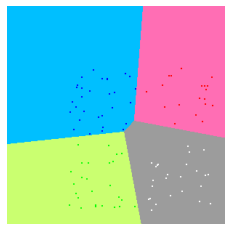


### Implementation of training procedure

With input data `x`, ground_truth `y`, and `model` as parameters, implement the gradient descent method to train your model and plot loss and accuracy vs training iterations

In [ ]:
def train(x,
          y,
          model,
          loss_function=cross_entropy_loss,
          accuracy_function=accuracy,
          max_iteration=500,
          learning_rate=1):
    """
    Args:
       x (2-d list): List of Values with shape: [n_samples, n_channels]
       y (1-d list): List of integers with shape: [n_samples]
       model (Module): Linear model
       loss_function (callable): Loss function to use during training
       accuracy_function (callable): Function used for calculating training accuracy
       max_iteration (int): Number of epochs to train model for
       learning_rate (numeric): Step size of the gradient update
    """
    for i in range(max_iteration):
        #TODO compute y_hat and calculate the loss between y_hat and y as well as
        # the accuracy of y_hat w.r.t y.
        # Each iteration represents one step (or epoch) of the training process. Based on what functions we have create, we have:
        y_hat = model(x) # This computes the outputs (logits) given an input data x. I think this is like the forward pass
        loss = loss_function(y_hat, y) # This compute the softmax loss (cross entropy loss) -- so like y_hat->softmax->cross_entropy_loss
        acc = accuracy_function(y_hat, y) # This computes the accuracy of the model's prediction agains the true labels

        # Mathias tip to zero out the gradients from previous iteration
        model.zero_grad()

        # DO YOUR THING Backprop:
        loss.backward()

        #TODO Then You will need to calculate gradient for all parameters, and
        #do gradient descent for all the parameters.
        #The list of parameters can be easily obtained by calling
        #model.parameters() which is implemented above.
        for param in model.parameters():
          param.data -= learning_rate * param.grad


        #Then plot the loss / accuracy vs iterations.
        if i % 20 == 19:
            print("iteration",i,"loss:",loss.data, "accuracy:",acc)
        ## record loss
        if i == 0 :
        # initialize L
            L = loss.data
            A = acc
        else:
            L = np.append(L,loss.data)
            A = np.append(A,acc)

    ## Plot Loss and Accuracy
    fig0=plt.figure(0)
    plt.plot(L,'-')
    plt.xlabel('Iteration', fontsize=18)
    plt.ylabel('Loss', fontsize=16)
    plt.show()
    fig1=plt.figure(1)
    plt.plot(A,'-')
    plt.xlabel('Iteration', fontsize=18)
    plt.ylabel('Accuracy', fontsize=16)
    plt.show()


### Train the model

Load the data, format it, instantiate your model and start training!

(100, 2) (100,) [0 1 2 3]
iteration 19 loss: 0.5720272950729679 accuracy: 0.95
iteration 39 loss: 0.42025388693117466 accuracy: 0.96
iteration 59 loss: 0.34913639832813415 accuracy: 0.97
iteration 79 loss: 0.3054370617495872 accuracy: 0.98
iteration 99 loss: 0.2750063783790085 accuracy: 0.98
iteration 119 loss: 0.25220225129871376 accuracy: 0.99
iteration 139 loss: 0.23426265806025032 accuracy: 0.99
iteration 159 loss: 0.21965221191110698 accuracy: 0.99
iteration 179 loss: 0.20743949659585614 accuracy: 0.99
iteration 199 loss: 0.19702210420354818 accuracy: 0.99
iteration 219 loss: 0.18799078788774679 accuracy: 0.99
iteration 239 loss: 0.18005646689858115 accuracy: 0.99
iteration 259 loss: 0.17300835296072603 accuracy: 0.99
iteration 279 loss: 0.16668863419435417 accuracy: 0.99
iteration 299 loss: 0.16097649421845756 accuracy: 0.99
iteration 319 loss: 0.15577765267165836 accuracy: 0.99
iteration 339 loss: 0.15101730565195712 accuracy: 1.0
iteration 359 loss: 0.14663523292687494 accuracy

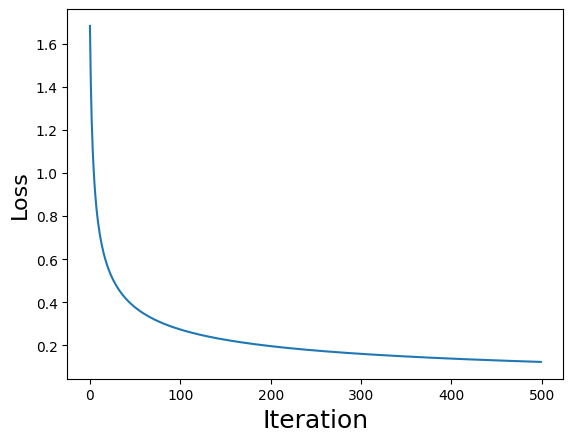

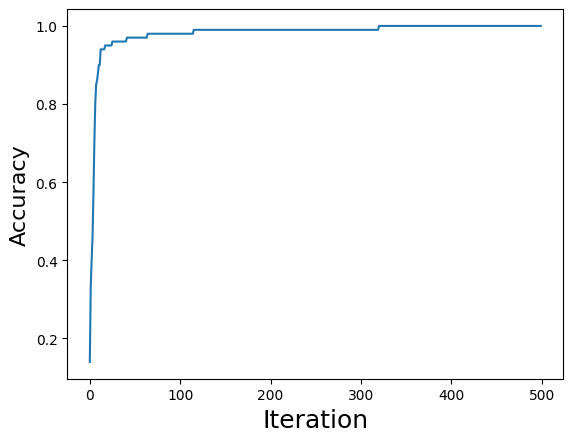

In [ ]:
## Load Q3 Dataset
datapath = './Q3_data.npz'
data = np.load(datapath)

## Load Data and Parse Shape Information
X = data['X']
Y = data['Y']
print(X.shape, Y.shape, np.unique(Y))
nin = X.shape[1]
nout = np.max(Y) + 1

## Initialize data using your Value class
x = [[Value(v) for v in sample] for sample in X]
y = [int(v) for v in Y]

## Initialize a Linear Model
linear_model = LinearLayer(nin, nout)

## Train the Model using Your Data
train(x, y, linear_model)

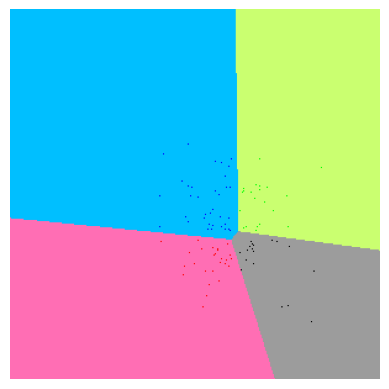

In [ ]:
## Visualize learned decision boundaries
visualization(X, Y, linear_model)

## Question 4

### a) Is this dataset linear separable?
load the dataset for this question and train a linear model on this dataset and report the performance

In [ ]:
## Load Q4 Dataset
datapath = './Q4_data.npz'
data = np.load(datapath)

## Parse Data and Identify Dimensions
X = data['X']
Y = data['Y']
nin = X.shape[1]
nout = int(np.max(Y)) + 1

## Initialize data using your value class
x = [[Value(v) for v in sample] for sample in X]
y = [int(v) for v in Y]

iteration 19 loss: 0.3787234202885632 accuracy: 0.8
iteration 39 loss: 0.35829764168103606 accuracy: 0.825
iteration 59 loss: 0.3505407263247142 accuracy: 0.825
iteration 79 loss: 0.3461724501035553 accuracy: 0.825
iteration 99 loss: 0.34333071439421314 accuracy: 0.825
iteration 119 loss: 0.3413405490816883 accuracy: 0.825
iteration 139 loss: 0.3398821084041131 accuracy: 0.825
iteration 159 loss: 0.3387801271342441 accuracy: 0.825
iteration 179 loss: 0.3379290468062617 accuracy: 0.85
iteration 199 loss: 0.33726082065619645 accuracy: 0.85
iteration 219 loss: 0.3367293142626733 accuracy: 0.85
iteration 239 loss: 0.33630204575274797 accuracy: 0.85
iteration 259 loss: 0.3359554827352038 accuracy: 0.85
iteration 279 loss: 0.3356721965949887 accuracy: 0.85
iteration 299 loss: 0.3354390519660699 accuracy: 0.85
iteration 319 loss: 0.33524600701747 accuracy: 0.85
iteration 339 loss: 0.33508529225174755 accuracy: 0.85
iteration 359 loss: 0.3349508336776048 accuracy: 0.85
iteration 379 loss: 0.33

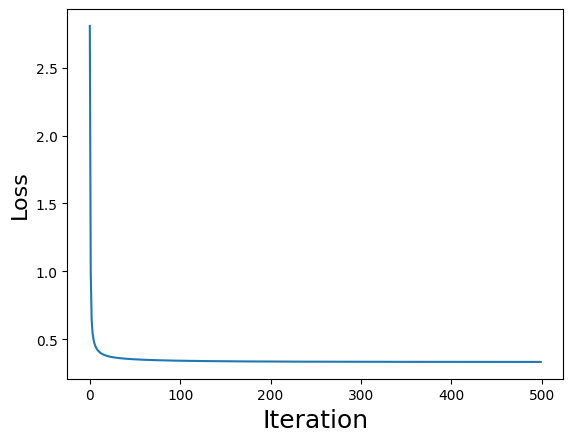

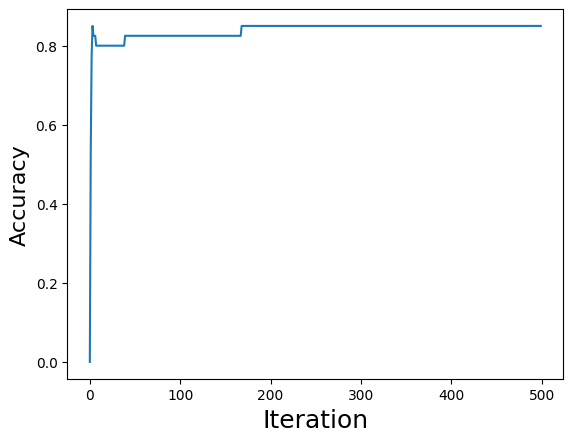

In [ ]:
## Initialize Linear Model
linear_model = LinearLayer(nin, nout)

## Train Model
train(x, y, linear_model)

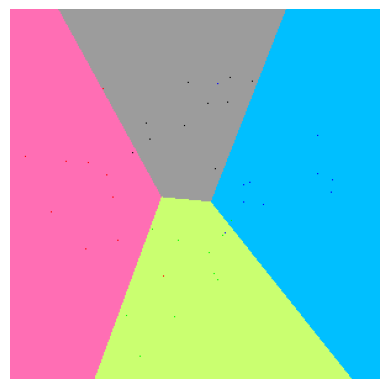

In [ ]:
## Visualize Learned Decision Boundary
visualization(X, Y, linear_model)

### b) Implementation of Multi Layer Perceptron (MLP)

Implement a class `MLP` to add arbitrary layers. You will need to implement the forward function to return results `out` with `x` fed into the model.

In [ ]:
class MLP(Module):

    """
    Multi Layer Perceptron
    """
    def __init__(self, dimensions):
        """
        Initialize multiple layers here in the list named self.linear_layers
        """
        assert isinstance(dimensions, list)
        assert len(dimensions) > 2
        self.linear_layers = []
        for i in range(len(dimensions) - 1):
            self.linear_layers.append(LinearLayer(dimensions[i], dimensions[i+1]))

    def __call__(self, x):
        """
        Args:
            x (2d-list): Two dimensional list of Values with shape [batch_size , nin]

        Returns:
            xout (2d-list): Two dimensional list of Values with shape [batch_size, nout]
        """
        #TODO Implement this function and return the output of a MLP
        # Pass through each hidden layer and apply ReLU activation
        for i in range(len(self.linear_layers) - 1):
            x = self.linear_layers[i](x)

            # Apply ReLU to each element of x, which is a 2D list of Values
            x = [[val.relu() for val in row] for row in x]  # Apply relu() to each Value object


        # For the output layer, we need to go back to using softmax
        xout = self.linear_layers[-1](x)
        xout = softmax(xout)
        return xout

    def parameters(self):
        """
        Get the parameters of each layer

        Args:
            None

        Returns:
            params (list of Values): Parameters of the MLP
        """
        return [p for layer in self.linear_layers for p in layer.parameters()]

    def zero_grad(self):
        """
        Zero out the gradient of each parameter
        """
        for p in self.parameters():
            p.grad = 0

Train your MLP model and visualize the decision boundary with ground truth points.

iteration 19 loss: 1.063289505723595 accuracy: 0.675
iteration 39 loss: 0.8758365733576281 accuracy: 0.9
iteration 59 loss: 0.864761971380082 accuracy: 0.9
iteration 79 loss: 0.8597916632579473 accuracy: 0.9
iteration 99 loss: 0.8566872198585993 accuracy: 0.9
iteration 119 loss: 0.8543027916080077 accuracy: 0.9
iteration 139 loss: 0.8525271277718574 accuracy: 0.9
iteration 159 loss: 0.8513016388527064 accuracy: 0.9
iteration 179 loss: 0.8504192019094449 accuracy: 0.9
iteration 199 loss: 0.849693613315778 accuracy: 0.9
iteration 219 loss: 0.849093078028984 accuracy: 0.9
iteration 239 loss: 0.848592994585959 accuracy: 0.9
iteration 259 loss: 0.8481700339958431 accuracy: 0.9
iteration 279 loss: 0.847806296383782 accuracy: 0.9
iteration 299 loss: 0.8474915856573015 accuracy: 0.9
iteration 319 loss: 0.8472165212421738 accuracy: 0.9
iteration 339 loss: 0.8469749284146924 accuracy: 0.9
iteration 359 loss: 0.8467607767790046 accuracy: 0.9
iteration 379 loss: 0.8465707843664094 accuracy: 0.9
it

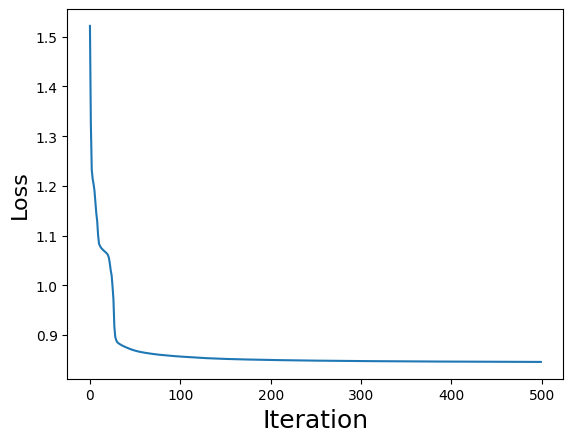

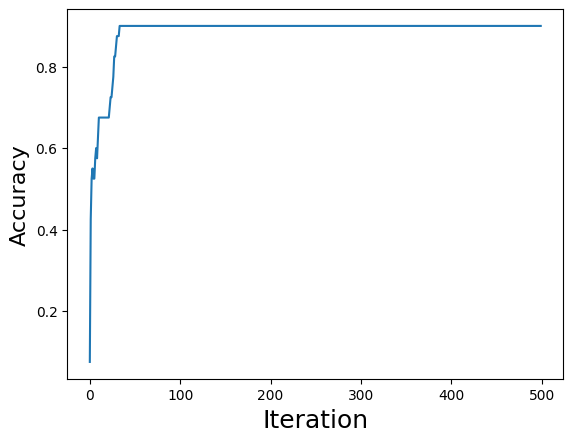

In [ ]:
## Initialize MLP with Given Parameters
mlp_model = MLP([nin, 40, nout])

## Train the MLP
train(x, y, mlp_model)

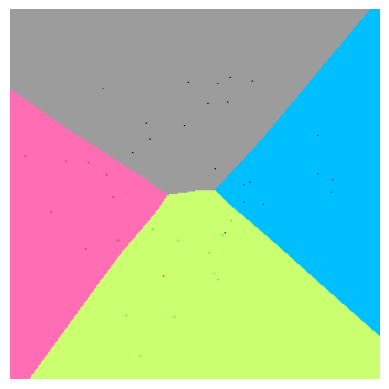

In [ ]:
## Visualize Decision Boundaries
visualization(X, Y, mlp_model)

# The time for this was 13 mins
# Try printing the gradient for debugging -- if the gradient is close to zero, something must be wrong. TA verified logic of X -> Linear -> ReLU -> Linear -> Softmax

## Acknowledgement

The design of the auto grade structure are based on the work https://github.com/karpathy/micrograd